__this__ notebook fine-tunes a transformer pre-trained with `pretrain_enru.ipynb` samplng trajectories from model.

In [1]:
%env CUDA_VISIBLE_DEVICES=1
%load_ext autoreload
%autoreload 2
import os, sys; sys.path.append('..')

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import numpy as np
import tensorflow as tf
tf.reset_default_graph()
sess = tf.InteractiveSession()

experiment_name = "enru_base_simplified"
# !rm -rf {experiment_name}
assert not os.path.exists(experiment_name), "please use unique name for each experiment"

### Data preprocessing

In [3]:
from prefetch_generator import background
from lib.data import form_batches, form_adaptive_batches_windowed, filter_by_len, cycle_shuffle, maxlen

class train:
    inp_lines = list(open('../data/wmt_enru/train.en'))
    out_lines = list(open('../data/wmt_enru/train.ru'))
    
    batcher = background(max_prefetch=256)(form_adaptive_batches_windowed)(
        filter_by_len(cycle_shuffle(zip(inp_lines, out_lines)), max_srclen=200, max_dstlen=200),
        max_size=4600, batch_size_max=256, split_len=10000,
    ) 

class dev:
    inp_lines = list(open('../data/wmt_enru/dev.en'))
    out_lines = list(open('../data/wmt_enru/dev.ru'))
    
    batcher = background(max_prefetch=256)(form_batches)(
        cycle_shuffle(zip(inp_lines, out_lines)),
        batch_size=256
    )


### Model & vocabs

In [4]:
from lib.voc import Voc
inp_voc = Voc.from_sequences(train.inp_lines)
out_voc = Voc.from_sequences(train.out_lines)

In [5]:
from lib.models import Transformer
hp = {
    'emb_size': 512,
    'hid_size': 512,
    'num_heads': 8,
    'ff_size': 2048,
    'num_layers': 6,
    'rescale_emb': True,
    'inp_emb_bias': False,
    'res_steps': 'nlda',
    'normalize_out': True,
    'attn_dropout': 0.0,
    'res_dropout': 0.1,
    'relu_dropout': 0.0,
    'share_emb': False,
}
model = Transformer('mod', inp_voc, out_voc, **hp)
sess.run(tf.global_variables_initializer())

In [6]:
from lib.saveload import save, load
load('./pretrained_model/weights.npz', tf.trainable_variables())

In [7]:
import nltk
from lib.inference import BeamSearchInserts
decoder = BeamSearchInserts(model)

def compute_bleu(batch, beam_size=32, beam_spread=50, len_alpha=1.0, 
                 maxlen=lambda inp_line: len(inp_line.split()) * 2 + 3, unbpe=True):
    """
    Computes corpora-level bleu on batch.
    Note: this isn't exactly the same BLEU as what's used for model evaluation, but very close to one.
        Use moses bleu for final evaluation.
    """
    translations, references = [], []
    for inp, ref_out in batch:
        hypo_scores = decoder.translate_line(inp, beam_size=beam_size, beam_spread=beam_spread,
                                             max_steps=maxlen(inp))
        hypo_scores = decoder.apply_length_penalty(hypo_scores, len_alpha=len_alpha)
        best_trans = max(hypo_scores.keys(), key=hypo_scores.get)
        if unbpe:
            best_trans = best_trans.replace('@@ ', '').replace(' `', '')
            ref_out = ref_out.replace('@@ ', '').replace(' `', '')
            
        translations.append(best_trans)
        references.append(ref_out)
    
    return nltk.bleu_score.corpus_bleu(
        [[ref.split()] for ref in references], 
        [trans.split() for trans in translations])

In [8]:
hypo_scores = decoder.translate_line('i am the monument to all your sins .',
                                     beam_size=4, beam_spread=10)
hypo_scores = decoder.apply_length_penalty(hypo_scores, len_alpha=1.5)
max(hypo_scores.keys(), key=hypo_scores.get)

'я - памятник всем гре `хам .'

### Training

In [9]:
from lib.trainer import SampleBasedTrainer
from lib.util import initialize_uninitialized_variables

trainer = SampleBasedTrainer(model, optimizer_opts=dict(base_lr=1e-4, warmup_time=4000))

initialize_uninitialized_variables()

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


/home/jheuristic/.local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [10]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
from tensorboardX import SummaryWriter
import pandas as pd
ewma = lambda x, span: pd.DataFrame({'x': x})['x'].ewm(span=span).mean().values

loss_history, acc_history, dev_bleu_history = [], [], []
writer = SummaryWriter(log_dir=experiment_name)

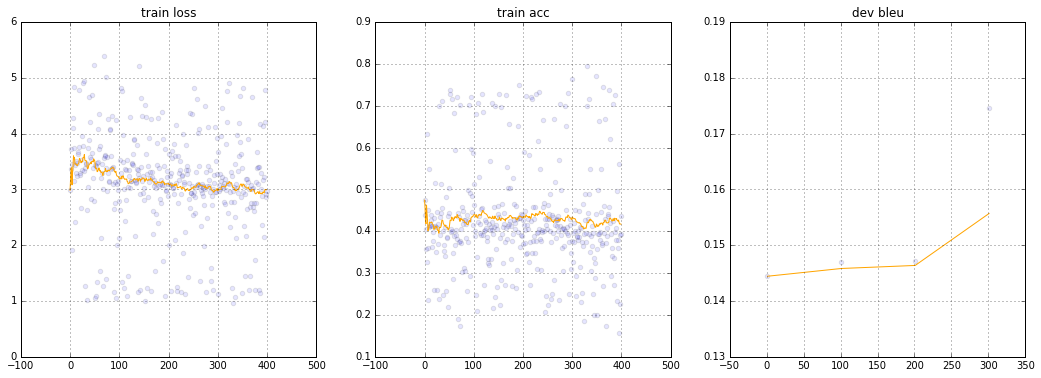

  0%|          | 457/100000 [2:34:39<561:26:38, 20.30s/it]

In [ ]:
from tqdm import trange

for t in trange(100000):
    batch = next(train.batcher)
    metrics_t = trainer.train_on_batch(batch, slice_max_len=4096)
    step = metrics_t['step']
    
    for key in metrics_t:
        writer.add_scalar(key, metrics_t[key], global_step=metrics_t['step'])
    loss_history.append(metrics_t['loss'])
    acc_history.append(metrics_t['acc'])
    
    if step % 100 == 0:
        dev_bleu_t = compute_bleu(next(dev.batcher))
        dev_bleu_history.append([len(loss_history), dev_bleu_t])
        writer.add_scalar('dev_BLEU', dev_bleu_t, global_step=step)
    
    if step % 1000 == 0:
        save(os.path.join(experiment_name, 'checkpoint_%i.npz' % step),
             tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))
        
    if step % 100 == 0:
        clear_output(True)
        plt.figure(figsize=[18, 6])
        plt.subplot(1, 3, 1)
        plt.scatter(np.arange(len(loss_history)), loss_history, alpha=0.1)
        plt.plot(ewma(loss_history, span=100), color='orange')
        plt.title('train loss'); plt.grid()
        
        plt.subplot(1, 3, 2)
        plt.scatter(np.arange(len(acc_history)), acc_history, alpha=0.1)
        plt.plot(ewma(acc_history, span=100), color='orange')
        plt.title('train acc'); plt.grid()
        
        plt.subplot(1, 3, 3)
        dev_bleu_steps, dev_bleu_values = zip(*dev_bleu_history)
        plt.scatter(dev_bleu_steps, dev_bleu_values, alpha=0.1)
        plt.plot(dev_bleu_steps, ewma(dev_bleu_values, span=10), color='orange')
        plt.title('dev bleu'); plt.grid();
        plt.show()

In [ ]:
from tfnn.task.seq2seq.tools.apply_bpe import BPEizer
src = BPEizer('../data/wmt_enru/en.bpe.voc')("i am the monument to all your sins")

print(src)
hypo_scores = decoder.translate_line(src.strip(), beam_size=64, beam_spread=100, verbose=True)